In [1]:
# MIT License (https://opensource.org/licenses/MIT)
# Copyright 2020 Ryan Hausen and Brant Robertson

# Morpheus



This notebook can be run interactively in Google Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/morpheus-project/morpheus/blob/master/examples/example_array.ipynb)

*note: if you're running in Colab, you can enable GPU/TPU acceleration, by going to: Edit->Notebook settings->Hardware accelerator*

## Table of contents
1. [Introduction](#introduction)
2. [Cataloging](#cataloging)
3. [Classifiying An Image](#classifying_an_image)
4. [Making A Segmentation Map](#making_a_segmentation_map)
4. [Colorizing A Morphological Classification](#colorizing_a_morphological_classification)

## Introduction <a name="introduction"></a>

This is a walkthrough for image classification using 
[Morpheus](https://github.com/morpheus-project/morpheus). Morpheus leverages a neural network 
to simultaneously perform source identification and 
morphological classification at the pixel level. The primary way to interact with Morpheus
is via the [Classifier](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier) 
class.

In [2]:
# if your running on Colab you need to install the package.
!pip install morpheus-astro


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from morpheus.classifier import Classifier
from morpheus.data import example

%matplotlib inline

2022-11-08 15:28:43.275634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 15:28:43.275685: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 15:28:43.493447: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 15:28:47.732726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 15:28:47.733187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

## First get a sample image to examine.

This is a sample taken from GOODS which includes multiple sources with different morphologies.

In [4]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
semap = fits.open(get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold=Low(Segmap-generation_Morpheus)/F105W_segmap.fits'))
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))

In [5]:
h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d

In [6]:
h = fits.getdata(h, ext=0)
j = fits.getdata(j, ext=0)
v = fits.getdata(v, ext=0)
z = fits.getdata(z, ext=0)

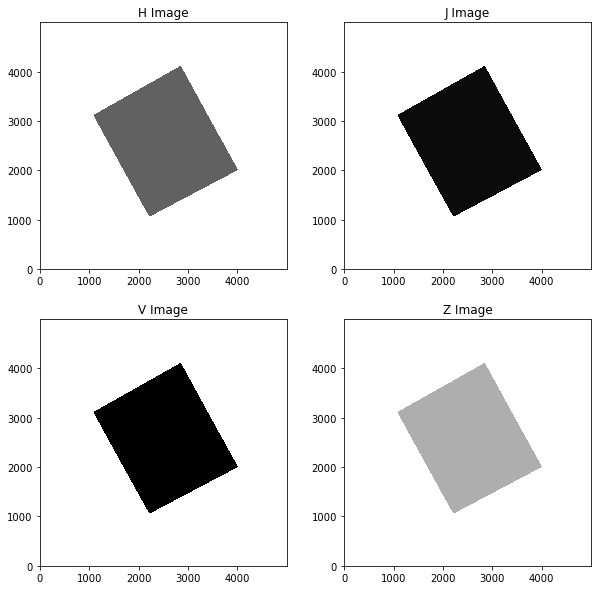

In [7]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [h,j,v,z], 'HJVZ'):
    ax.set_title(f'{band} Image')
    ax.imshow(arr, origin='lower', cmap='gray')
plt.show()

## Classify Images <a name="classification"></a>

To classify an image, use [Classifer.classify](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.classify).
The arguments can be either a file path or a numpy array. The output is a dictionary that contains the
classifications as numpy arrays.

The output is a dictionary that contains a mapping for each pixel which represents the 
probability that a pixel belongs to one of the following classes:

- Spheroid
- Disk
- Irregular
- Point Source (Compact)
- Background

It also contains a mapping for `n`, which indicates how many times a classification was
recorded for that pixel

In [8]:
classified = Classifier.classify(h=h, j=j, v=v, z=z)

classifying:   0%|          | 0/24611 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate

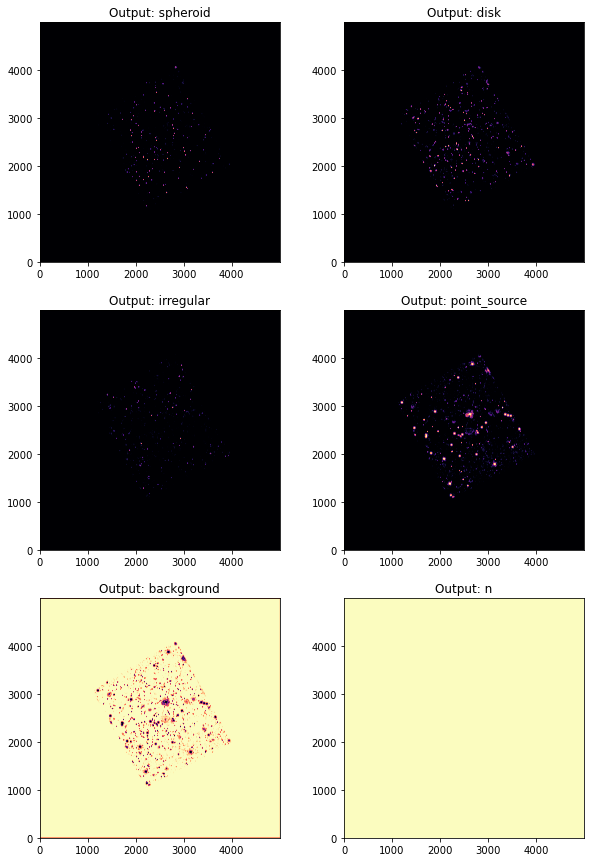

In [9]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = np.array(axes).flatten()

for i, k in enumerate(classified):
    axes[i].set_title(f'Output: {k}')
    axes[i].imshow(classified[k], origin='lower', vmin=0, vmax=1, cmap='magma')
plt.show()

## Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [10]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(h, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, h, mask=mask)

/tmp/ipykernel_46883/1166587082.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(h, np.int)


Building Markers...
Watershedding...


Deblending: 100%|██████████| 489/489 [00:00<00:00, 1037.36it/s]


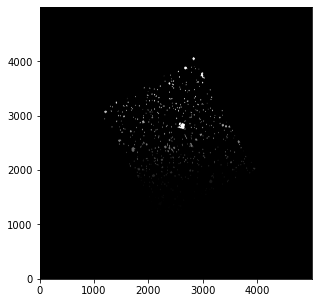

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='gray')
plt.show()

## Cataloging <a name="cataloging"></a>

Morpheus provides a cataloging functionality via [Classifier.catalog_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.catalog_from_classified)
for images that will return all of the detected sources and their morphological classifications.


In [12]:
catalog = Classifier.catalog_from_classified(classified, h, segmap)

In [13]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[1141, 2228]	[0.   0.   0.01 0.99]
2		[1170, 2219]	[0.74 0.   0.   0.26]
3		[1209, 2406]	[0.09 0.03 0.   0.88]
4		[1278, 2598]	[0.   0.99 0.01 0.  ]
5		[1280, 2527]	[0.   0.79 0.21 0.01]
6		[1284, 2158]	[0.05 0.07 0.85 0.03]
7		[1315, 2370]	[0.04 0.93 0.02 0.01]
8		[1339, 2580]	[0.   0.04 0.01 0.95]
9		[1386, 2204]	[0. 0. 0. 1.]
10		[1365, 2454]	[0.39 0.   0.57 0.03]
11		[1424, 2054]	[0.02 0.   0.   0.98]
12		[1446, 2276]	[0.94 0.06 0.   0.  ]
13		[1448, 2640]	[0.91 0.08 0.   0.  ]
14		[1470, 2482]	[0. 0. 0. 1.]
15		[1482, 2173]	[0.   0.98 0.02 0.  ]
16		[1485, 2835]	[-0.    0.98  0.02  0.  ]
17		[1500, 2257]	[0.   0.94 0.06 0.  ]
18		[1496, 2129]	[-0.  0.  0.  1.]
19		[1508, 2520]	[0. 0. 0. 1.]
20		[1513, 2016]	[-0.  0.  0.  1.]
21		[1533, 2268]	[0.   0.08 0.92 0.01]
22		[1555, 3050]	[0.99 0.01 0.   0.  ]
23		[1577, 2976]	[ 0.02 -0.    0.    0.98]
24		[1599, 2068]	[0.98 0.01 0.01 0.  ]
25		[1601, 2578]	[0.99 0.01 0.01 0.  ]
26		[1

## Colorizing A Morphological Classification <a name="colorizing_a_morphological_classification"></a>

Use [Classifier.colorize_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified)  to make an RGB. The colors in the output have the following meanings:

- Red = Spheroid
- Blue = Disk
- Green = Irregular
- Yellow = Point Source (compact)
- Back = Background

Note when Morpheus doesn't output a strong classification for any one class they are colored white.

For more information on the coloring scheme see the [documentation](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified).

100%|██████████| 5000/5000 [00:49<00:00, 101.89it/s]


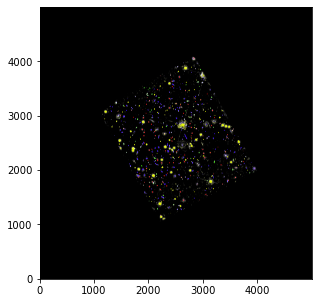

In [14]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(5, 5))
plt.imshow(rgb, origin='lower')
plt.show()

In [17]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS
import pandas as pd 
from astropy.io import fits

h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d
h_header = fits.open(h)[0]
j_header = fits.open(j)[0]
v_header = fits.open(v)[0]
z_header = fits.open(z)[0]

wcs = WCS(h_header.header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')


morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    #morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).ra.degree
    #morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).dec.degree
    morpheus_result['x'][i] = morpheus_result['location'][i][0]
    morpheus_result['y'][i] = morpheus_result['location'][i][1]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+0
morpheus_result['real_y'] = morpheus_result['y']+0

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree

# morpheus_result['radec'] = pixel_to_skycoord(morpheus_result['location'][0], morpheus_result['location'][1], wcs)


/tmp/ipykernel_46883/3291266960.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_46883/3291266960.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_46883/3291266960.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0

In [18]:
morpheus_result.to_csv("/data/jip/2nd TASK/Morpheus_Trying/SMACS_F105-F160/morpheus_result_normal.csv")
morpheus_result


,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[1141, 2228]","[0.0016573647025177258, 0.0021817991734690892,...",110.912987,-73.458704,1141.0,2228.0,0.001657,0.002182,0.007242,0.988919,1141.0,2228.0
1,2,"[1170, 2219]","[0.7436354202638189, 0.000780372975141567, 5.3...",110.911290,-73.458855,1170.0,2219.0,0.743635,0.000780,0.000054,0.255530,1170.0,2219.0
2,3,"[1209, 2406]","[0.08989809332819902, 0.029671867713086462, 0....",110.908994,-73.455739,1209.0,2406.0,0.089898,0.029672,0.001516,0.878914,1209.0,2406.0
3,4,"[1278, 2598]","[0.00010179398054179144, 0.9881299428262994, 0...",110.904942,-73.452540,1278.0,2598.0,0.000102,0.988130,0.011768,0.000000,1278.0,2598.0
4,5,"[1280, 2527]","[5.115303287620794e-06, 0.7866715906354904, 0....",110.904830,-73.453724,1280.0,2527.0,0.000005,0.786672,0.205418,0.007905,1280.0,2527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,487,"[3892, 2784]","[0.0110505591469997, 0.0, 0.0, 0.9889494408530...",110.751989,-73.449437,3892.0,2784.0,0.011051,0.000000,0.000000,0.988949,3892.0,2784.0
486,488,"[3909, 2831]","[0.2305902258584911, 0.6850258404230789, 0.056...",110.750998,-73.448653,3909.0,2831.0,0.230590,0.685026,0.056798,0.027586,3909.0,2831.0
487,489,"[4071, 2831]","[0.9999186072085642, 4.772527622929624e-05, -7...",110.741520,-73.448649,4071.0,2831.0,0.999919,0.000048,-0.000007,0.000041,4071.0,2831.0
488,490,"[2834, 2625]","[0.0006390842614897183, 0.006462716135604437, ...",110.813887,-73.452102,2834.0,2625.0,0.000639,0.006463,0.002314,0.990584,2834.0,2625.0


# Next Step with total image

In [ ]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
semap = fits.open(get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold=Low(Segmap-generation_Morpheus)/F105W_segmap.fits'))
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))
ftotal_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_total_v1_drz.fits'))

In [ ]:
h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, ftotal_nircam_i2d

In [ ]:
h = fits.getdata(h, ext=0)
j = fits.getdata(j, ext=0)
v = fits.getdata(v, ext=0)
z = fits.getdata(z, ext=0)

In [ ]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [h,j,v,z], 'HJVZ'):
    ax.set_title(f'{band} Image')
    ax.imshow(arr, origin='lower', cmap='gray')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
classified = Classifier.classify(h=h, j=j, v=v, z=z)

classifying:   0%|          | 0/24611 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate

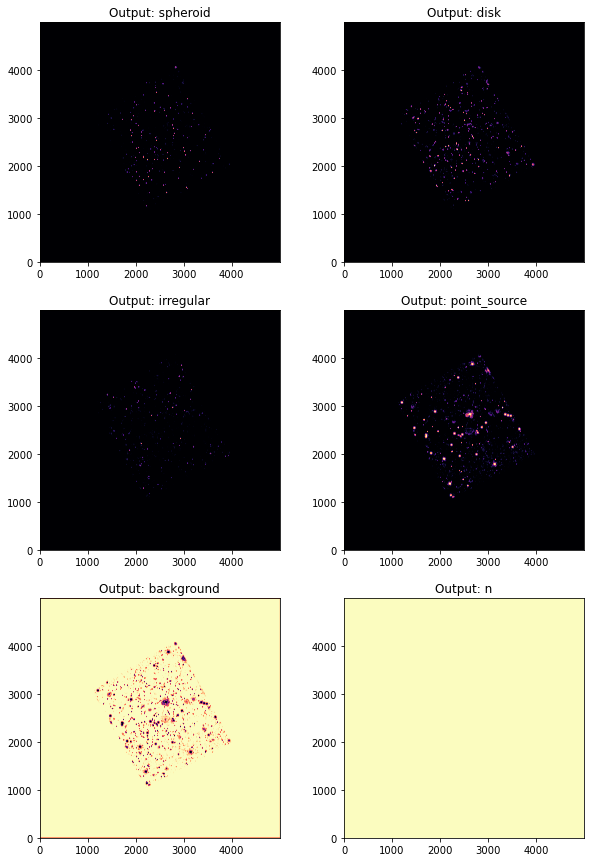

In [ ]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = np.array(axes).flatten()

for i, k in enumerate(classified):
    axes[i].set_title(f'Output: {k}')
    axes[i].imshow(classified[k], origin='lower', vmin=0, vmax=1, cmap='magma')
plt.show()

## Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [ ]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(h, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, h, mask=mask)

/tmp/ipykernel_19407/1166587082.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(h, np.int)


Building Markers...
Watershedding...


Deblending: 100%|██████████| 489/489 [00:00<00:00, 578.02it/s]


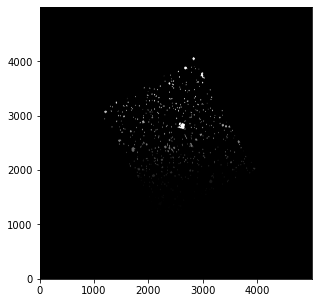

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='gray')
plt.show()

In [ ]:
catalog = Classifier.catalog_from_classified(classified, h, segmap)

In [ ]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[1141, 2228]	[0.   0.   0.01 0.99]
2		[1170, 2219]	[0.74 0.   0.   0.26]
3		[1209, 2406]	[0.09 0.03 0.   0.88]
4		[1278, 2598]	[0.   0.99 0.01 0.  ]
5		[1280, 2527]	[0.   0.79 0.21 0.01]
6		[1284, 2158]	[0.05 0.07 0.85 0.03]
7		[1315, 2370]	[0.04 0.93 0.02 0.01]
8		[1339, 2580]	[0.   0.04 0.01 0.95]
9		[1386, 2204]	[0. 0. 0. 1.]
10		[1365, 2454]	[0.39 0.   0.57 0.03]
11		[1424, 2054]	[0.02 0.   0.   0.98]
12		[1446, 2276]	[0.94 0.06 0.   0.  ]
13		[1448, 2640]	[0.91 0.08 0.   0.  ]
14		[1470, 2482]	[0. 0. 0. 1.]
15		[1482, 2173]	[0.   0.98 0.02 0.  ]
16		[1485, 2835]	[-0.    0.98  0.02  0.  ]
17		[1500, 2257]	[0.   0.94 0.06 0.  ]
18		[1496, 2129]	[-0.  0.  0.  1.]
19		[1508, 2520]	[0. 0. 0. 1.]
20		[1513, 2016]	[-0.  0.  0.  1.]
21		[1533, 2268]	[0.   0.08 0.92 0.01]
22		[1555, 3050]	[0.99 0.01 0.   0.  ]
23		[1577, 2976]	[ 0.02 -0.    0.    0.98]
24		[1599, 2068]	[0.98 0.01 0.01 0.  ]
25		[1601, 2578]	[0.99 0.01 0.01 0.  ]
26		[1

100%|██████████| 5000/5000 [01:25<00:00, 58.69it/s]


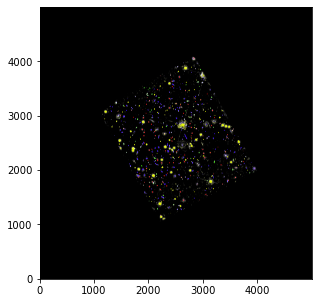

In [ ]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(5, 5))
plt.imshow(rgb, origin='lower')
plt.show()

In [ ]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS
import pandas as pd 
from astropy.io import fits

h_header = fits.open(h)[0]
j_header = fits.open(j)[0]
v_header = fits.open(v)[0]
z_header = fits.open(z)[0]

wcs = WCS(h_header.header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')


morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    #morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).ra.degree
    #morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).dec.degree
    morpheus_result['x'][i] = morpheus_result['location'][i][0]
    morpheus_result['y'][i] = morpheus_result['location'][i][1]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+0
morpheus_result['real_y'] = morpheus_result['y']+0

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree

# morpheus_result['radec'] = pixel_to_skycoord(morpheus_result['location'][0], morpheus_result['location'][1], wcs)


In [ ]:
morpheus_result.to_csv("/data/jip/2nd TASK/Morpheus_Trying/SMACS_F105-F160/morpheus_result_totalincluded.csv")
morpheus_result
